In [1]:
import bioframe as bf
from datasets import load_dataset
from gpn.data import Genome, load_table, load_dataset_from_file_or_dir
from liftover import get_lifter
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import polars as pl
from scipy.spatial.distance import cdist
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, SelectFdr
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
import torch
from tqdm import tqdm
import yaml

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = "Height"
#dataset = "IBD"
V = pd.read_parquet(f"../../results/dataset/gwas_gokcen_{dataset}_cre_matched_9/test.parquet")
V

,chrom,pos,ref,alt,MAF,PIP,label,consequence,tss_dist
0,1,1915022,C,T,0.276890,9.543050e-05,False,pELS,85
1,1,2293397,G,A,0.369530,9.999190e-01,True,dELS,65077
2,1,2299360,T,C,0.370600,1.527130e-06,False,dELS,71040
3,1,2345557,C,T,0.169220,1.810760e-06,False,dELS,42779
4,1,3380586,T,C,0.117120,7.019680e-05,False,dELS,15904
...,...,...,...,...,...,...,...,...,...
1425,22,44864238,G,A,0.098487,4.804090e-08,False,dELS,111532
1426,22,44865957,G,A,0.098344,5.548170e-08,False,dELS,113251
1427,22,48357416,A,G,0.054967,1.125850e-04,False,CTCF-only,132136
1428,22,48806571,C,T,0.106510,8.320650e-04,False,dELS,113323


In [3]:
features_paths = [
    "GPN-MSA_InnerProducts",
    "CADD",
    #"Borzoi_L2",
]
features = []
for features_path in features_paths:
    df = pd.read_parquet(f"../../results/dataset/gwas_gokcen_{dataset}_cre_matched_9/features/{features_path}.parquet")
    df = df.fillna(df.mean())
    df.columns = [f"{features_path}_{col}" for col in df.columns]
    features += df.columns.tolist()
    V = pd.concat([V, df], axis=1)
features

['GPN-MSA_InnerProducts_embedding_0',
 'GPN-MSA_InnerProducts_embedding_1',
 'GPN-MSA_InnerProducts_embedding_2',
 'GPN-MSA_InnerProducts_embedding_3',
 'GPN-MSA_InnerProducts_embedding_4',
 'GPN-MSA_InnerProducts_embedding_5',
 'GPN-MSA_InnerProducts_embedding_6',
 'GPN-MSA_InnerProducts_embedding_7',
 'GPN-MSA_InnerProducts_embedding_8',
 'GPN-MSA_InnerProducts_embedding_9',
 'GPN-MSA_InnerProducts_embedding_10',
 'GPN-MSA_InnerProducts_embedding_11',
 'GPN-MSA_InnerProducts_embedding_12',
 'GPN-MSA_InnerProducts_embedding_13',
 'GPN-MSA_InnerProducts_embedding_14',
 'GPN-MSA_InnerProducts_embedding_15',
 'GPN-MSA_InnerProducts_embedding_16',
 'GPN-MSA_InnerProducts_embedding_17',
 'GPN-MSA_InnerProducts_embedding_18',
 'GPN-MSA_InnerProducts_embedding_19',
 'GPN-MSA_InnerProducts_embedding_20',
 'GPN-MSA_InnerProducts_embedding_21',
 'GPN-MSA_InnerProducts_embedding_22',
 'GPN-MSA_InnerProducts_embedding_23',
 'GPN-MSA_InnerProducts_embedding_24',
 'GPN-MSA_InnerProducts_embedding_2

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


ValueError: The condensed distance matrix must contain only finite values.

<Figure size 1440x1440 with 0 Axes>

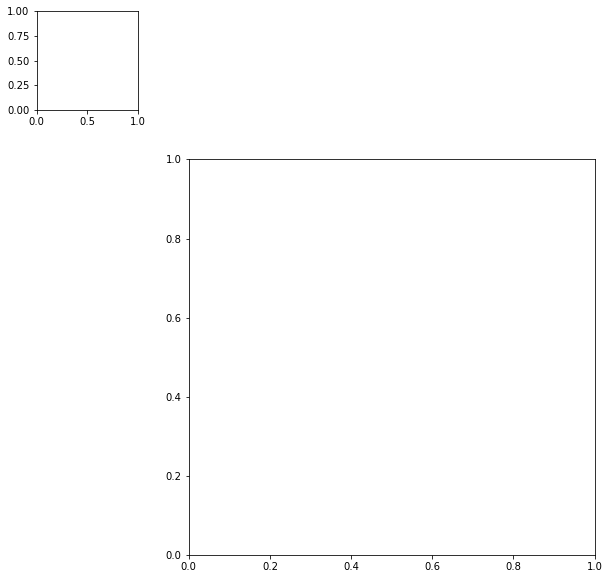

In [12]:
plt.figure(figsize=(20, 20))
#sns.heatmap(V[["label"] + features].corr(method="spearman"))
sns.clustermap(V[["label"] + features].corr(method="spearman"))

In [106]:
X = features
y = V.label
mask_train = V.chrom.isin([str(i) for i in range(1, 23, 2)] + ["X"])
X_train = X[mask_train]
y_train = y[mask_train]
X_test = X[~mask_train]
y_test = y[~mask_train]
balanced = True

clf = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', RobustScaler()),
    #('feature_selection', SelectKBest(score_func=f_classif, k=30)),
    #('feature_selection', SelectFdr(score_func=f_classif, alpha=0.05)),
    #('feature_selection', SelectFromModel(LogisticRegression(C=1e-1, penalty="l1", random_state=42, solver="saga"))),
    ('linear', LogisticRegressionCV(
        class_weight="balanced",
        scoring="roc_auc" if balanced else "average_precision",
        Cs=np.logspace(-10, 10, 41),
        cv=3,
        random_state=42,
        n_jobs=-1,
    ))
    #(
    #    'random_forest',
    #    RandomForestClassifier(
    #        class_weight="balanced",
    #        n_estimators=1000,
    #        random_state=42,
    #        n_jobs=-1,
    #    )
    #),
])
clf.fit(X_train, y_train)
pred = clf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, pred)

/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: ['MMSp_acceptorIntron' 'MMSp_acceptor']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

0.5800303592511384